  customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0   CUST0000    Male              0      No        Yes      23           No   
1   CUST0001  Female              0     Yes         No      43           No   
2   CUST0002    Male              1      No         No      51          Yes   
3   CUST0003    Male              1      No         No      72          Yes   
4   CUST0004    Male              1      No         No      25          Yes   

      MultipleLines InternetService       OnlineSecurity  ...  \
0  No phone service              No  No internet service  ...   
1  No phone service             DSL                  Yes  ...   
2                No             DSL                   No  ...   
3               Yes             DSL                  Yes  ...   
4               Yes             DSL                   No  ...   

      DeviceProtection          TechSupport          StreamingTV  \
0  No internet service  No internet service  No internet service  

C:\Users\91638\AppData\Local\Temp\ipykernel_38048\2838834738.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)
C:\Users\91638\AppData\Local\Temp\ipykernel_38048\2838834738.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Shape of data after Variance Threshold: (5880, 5925)
Shape of data after PCA: (5880, 5583)
Cross-validation scores: [0.48300971 0.48967193 0.48967193 0.49210207 0.4945322 ]
Average cross-validation score: 0.48979756750698955


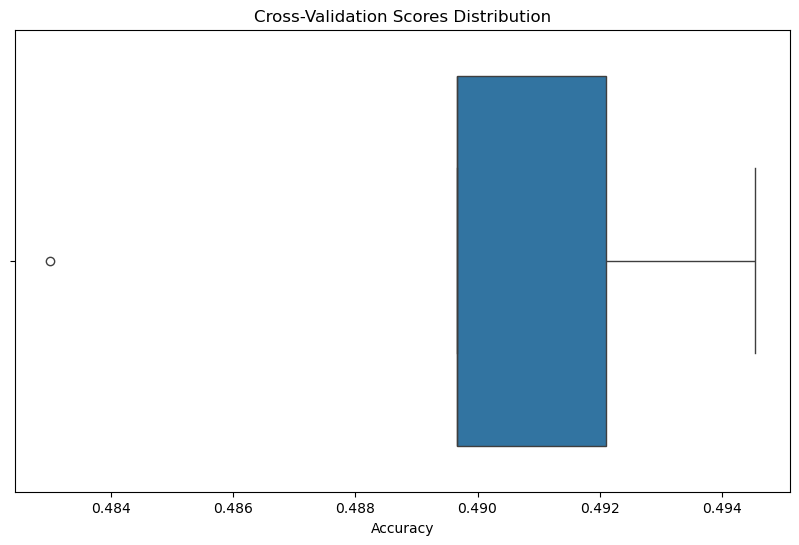

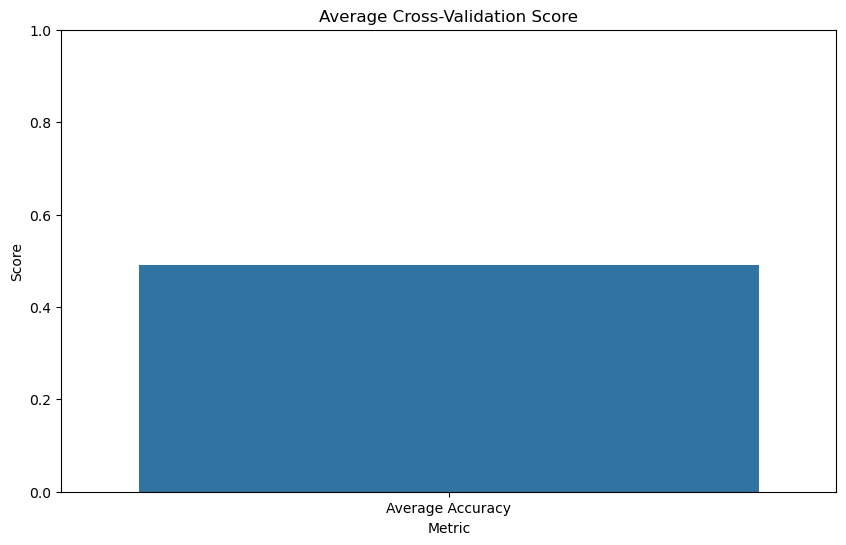

Confusion Matrix:
 [[ 47 827]
 [ 47 843]]

Accuracy: 0.5045351473922902

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.10       874
           1       0.50      0.95      0.66       890

    accuracy                           0.50      1764
   macro avg       0.50      0.50      0.38      1764
weighted avg       0.50      0.50      0.38      1764



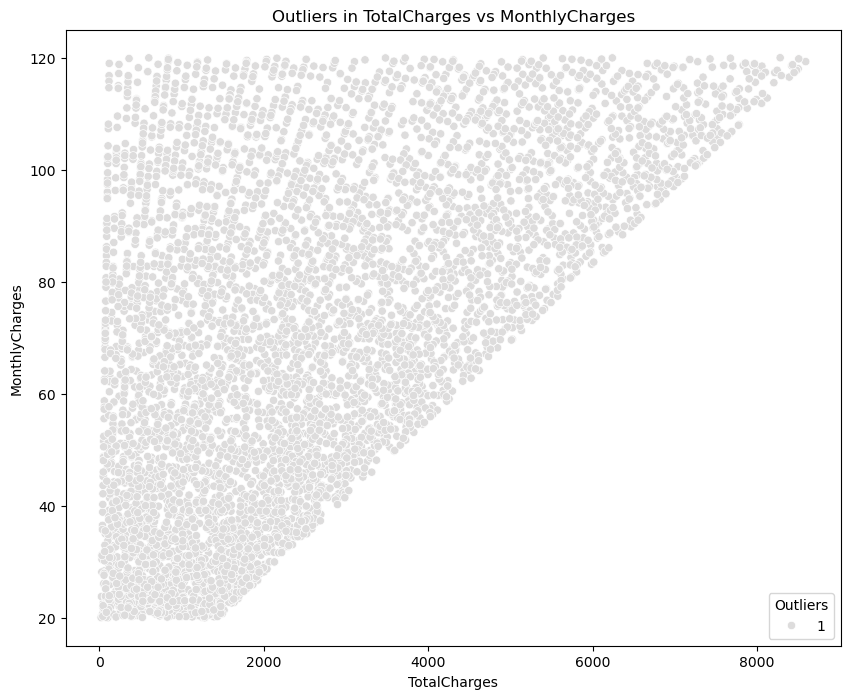

                  Feature  Importance
2          MonthlyCharges    0.076402
3            TotalCharges    0.075126
1                  tenure    0.070442
0           SeniorCitizen    0.019463
5888        Dependents_No    0.014677
...                   ...         ...
1134  customerID_CUST1130    0.000012
1957  customerID_CUST1953    0.000012
2287  customerID_CUST2283    0.000012
597   customerID_CUST0593    0.000011
5570  customerID_CUST5566    0.000009

[5925 rows x 2 columns]


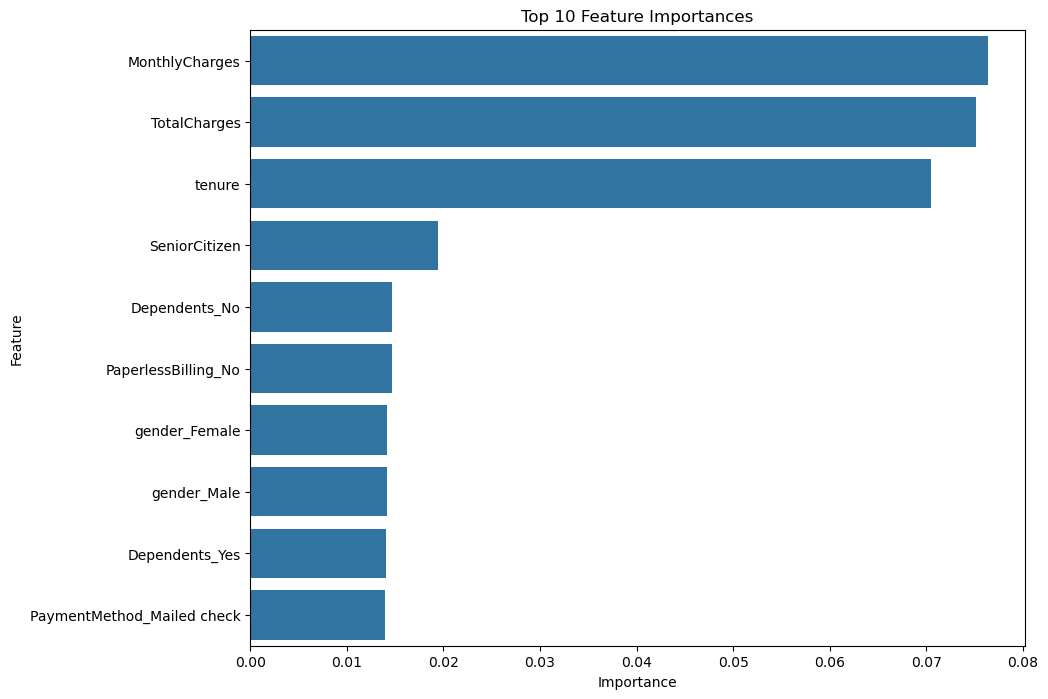

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import randint

data = pd.read_csv(r"D:\churn data\customer_churn_data.csv")

data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print(data.head())
print(data.info())
print(data.describe())

for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column].fillna(data[column].median(), inplace=True)
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

data = pd.get_dummies(data)

print(data.isnull().sum().sum())

X = data.drop('Churn', axis=1)
y = data['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

threshold = 0.1
vt = VarianceThreshold(threshold)
X_vt = vt.fit_transform(X_scaled)
print("Shape of data after Variance Threshold:", X_vt.shape)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_vt)
print("Shape of data after PCA:", X_pca.shape)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

skf = StratifiedKFold(n_splits=5)

knn = KNeighborsClassifier(n_neighbors=5)

cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
average_cv_score = cv_scores.mean()
print("Average cross-validation score:", average_cv_score)

cv_scores_df = pd.DataFrame(cv_scores, columns=['Accuracy'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_scores_df, x='Accuracy')
plt.title('Cross-Validation Scores Distribution')
plt.xlabel('Accuracy')
plt.show()

average_cv_score = cv_scores.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=['Average Accuracy'], y=[average_cv_score])
plt.title('Average Cross-Validation Score')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1) 
plt.show()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", class_report)

lof = LocalOutlierFactor(n_neighbors=20)
outliers = lof.fit_predict(X_scaled)

data['Outliers'] = outliers

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='TotalCharges', y='MonthlyCharges', hue='Outliers', palette='coolwarm')
plt.title('Outliers in TotalCharges vs MonthlyCharges')
plt.show()

rf = RandomForestClassifier()
rf.fit(X_scaled, y)
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.show()


# Hyperparameter tuning with Random Search
param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=skf, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print("Best parameters found by Random Search:", random_search.best_params_)
best_rf_random = random_search.best_estimator_
y_pred_random = best_rf_random.predict(X_test)
print("Accuracy with Random Search:", accuracy_score(y_test, y_pred_random))

# Hyperparameter tuning with Grid Search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters found by Grid Search:", grid_search.best_params_)
best_rf_grid = grid_search.best_estimator_
y_pred_grid = best_rf_grid.predict(X_test)
print("Accuracy with Grid Search:", accuracy_score(y_test, y_pred_grid))

